In [1]:
from glob import glob
import json
import os
import sys
import time

import matplotlib.pyplot as plt
import mne
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib qt

#### Plot electrodes

### Load experiment

In [5]:
recfolder = r'E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [6]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [7]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [8]:
print(eeg_ts[0])
print(eeg_ts[-1])
print(len(eeg_ts))

79.3536544827942
6682.103505585035
16506880


### Create MNE Raw object

In [9]:
ch_names = [str(x) for x in eeg_chs]
info = mne.create_info(ch_names=ch_names, sfreq=exp.ephys_params['EEG']['sample_rate'], ch_types='eeg')
# can add bad channels to info

In [10]:
mne_raw = mne.io.RawArray(eeg_data.T[eeg_chs,:]*1e-3, info)
# for mne.io.RawArray, eeg channels must be in Volts

Creating RawArray with float64 data, n_channels=30, n_times=16506880
    Range : 0 ... 16506879 =      0.000 ...  6602.752 secs
Ready.


Using matplotlib as 2D backend.


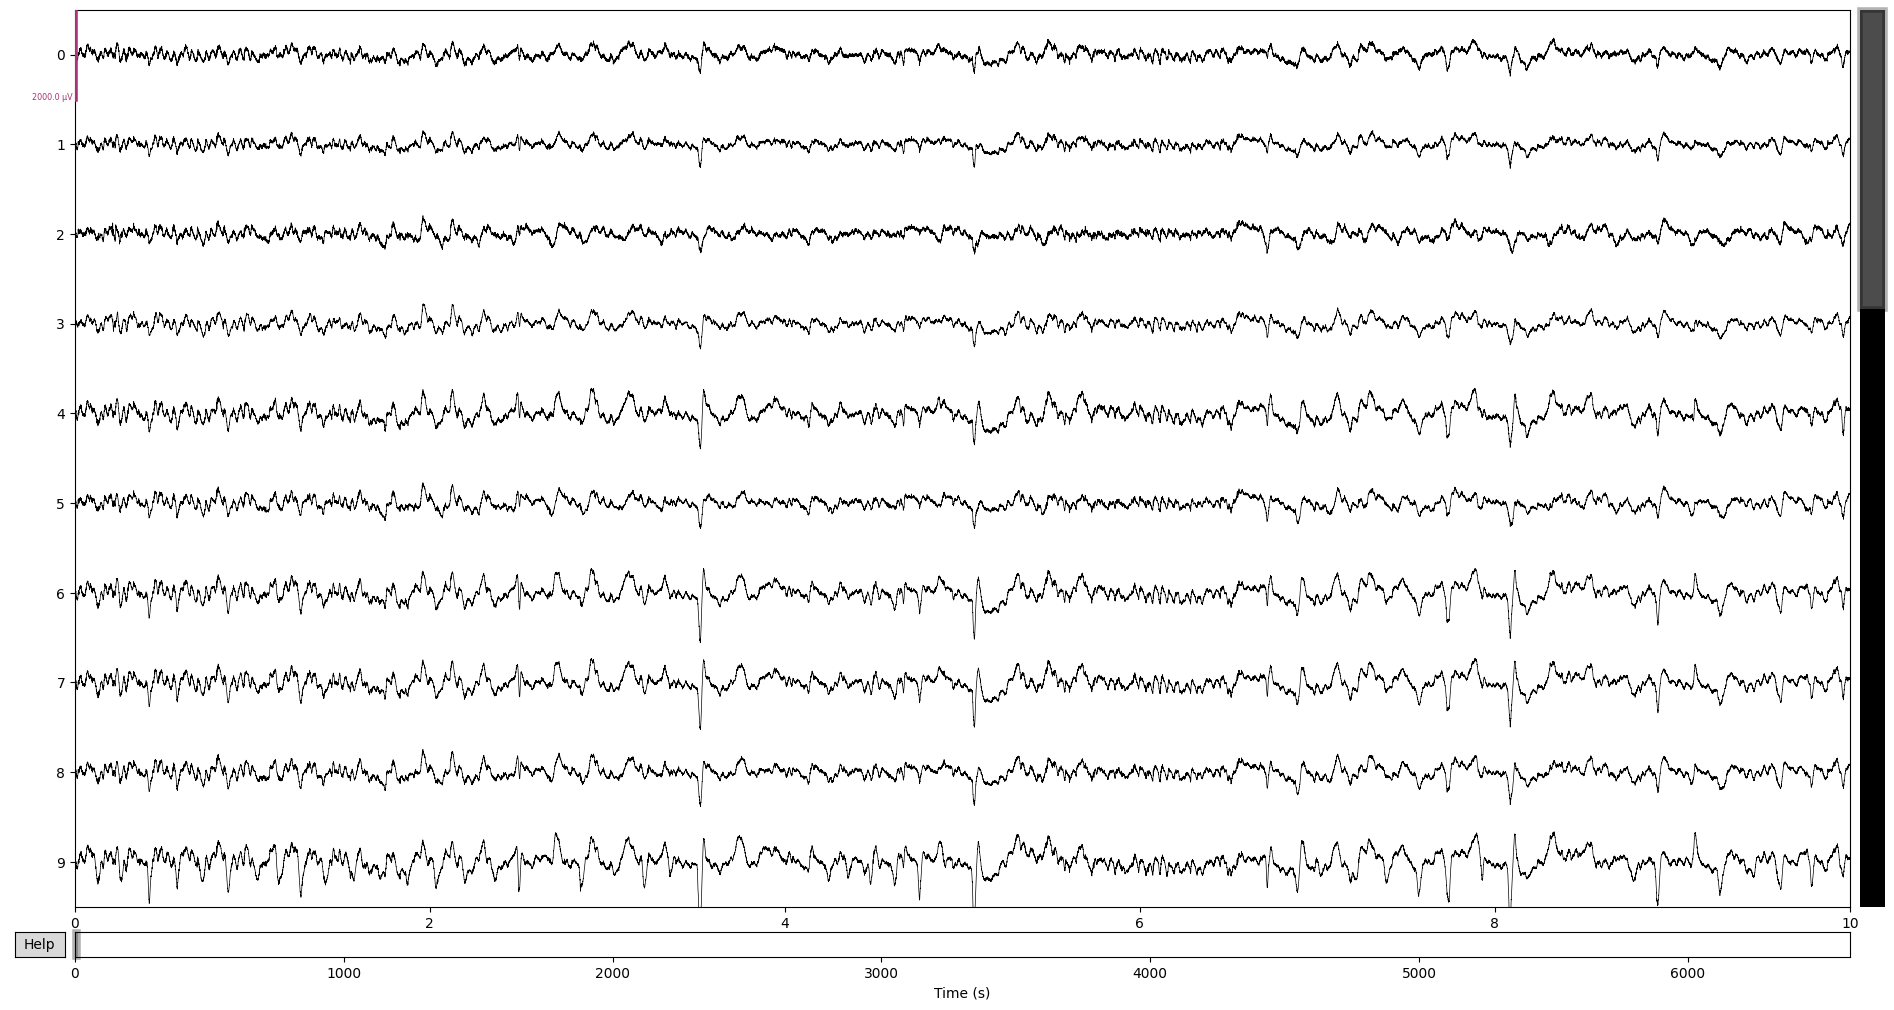

Channels marked as bad:
none


In [11]:
scalings = {'eeg': 1e-3}
mne_raw.plot(n_channels=10, scalings=scalings)

In [12]:
interactive_annot = mne_raw.annotations

In [13]:
type(interactive_annot)

mne.annotations.Annotations

In [14]:
print(interactive_annot)

<Annotations | 102 segments: SWD (80), maybe (22)>


In [15]:
print(interactive_annot[0])

OrderedDict([('onset', 4.905730028169014), ('duration', 0.6310111549295776), ('description', 'SWD'), ('orig_time', None)])


#### Make manual annotations into dataframe

Also need to adjust onset time to consider our timestamps. And include offset column.

In [16]:
man_annot_df = pd.DataFrame(interactive_annot).drop('orig_time', axis=1)
man_annot_df['onset'] = man_annot_df['onset'] + eeg_ts[0]
man_annot_df['offset'] = man_annot_df['onset'] + man_annot_df['duration']
man_annot_df.head()

,onset,duration,description,offset
0,124.445446,0.631011,SWD,125.076457
1,125.183503,0.585939,maybe,125.769442
2,127.418704,4.079036,SWD,131.497740
3,139.383471,1.357801,SWD,140.741272
4,140.915927,0.771862,maybe,141.687789


## Plot some window of all channels

In [49]:
plot_window = [120., 144.] # choose values in s, must match master timestamp values

plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]

In [53]:
sep = 1.5 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(9, 9), constrained_layout=True)
for chi in eeg_chs:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(eeg_ts[plot_inds], eeg_data[plot_inds, chi] + sep*chi, color=trace_color, linewidth=0.8)

ax.set_xlim(plot_window)
ax.set_xlabel('Time (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(eeg_chs)
ax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))
ax.set_title('{} ({})\nraw EEG ({:d} s window)'.format(exp.mouse, exp_tag, int(plot_window[1]-plot_window[0])))

### SAVE ###
fig_name = '{}_rawEEGstack_{:d}-{:d}s.png'.format(exp_tag, int(plot_window[0]), int(plot_window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

fig.show()

Apply a bandpass filter.

In [12]:
bpb, bpa = signal.butter(3, np.array([0.1, 20])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

<IPython.core.display.Javascript object>


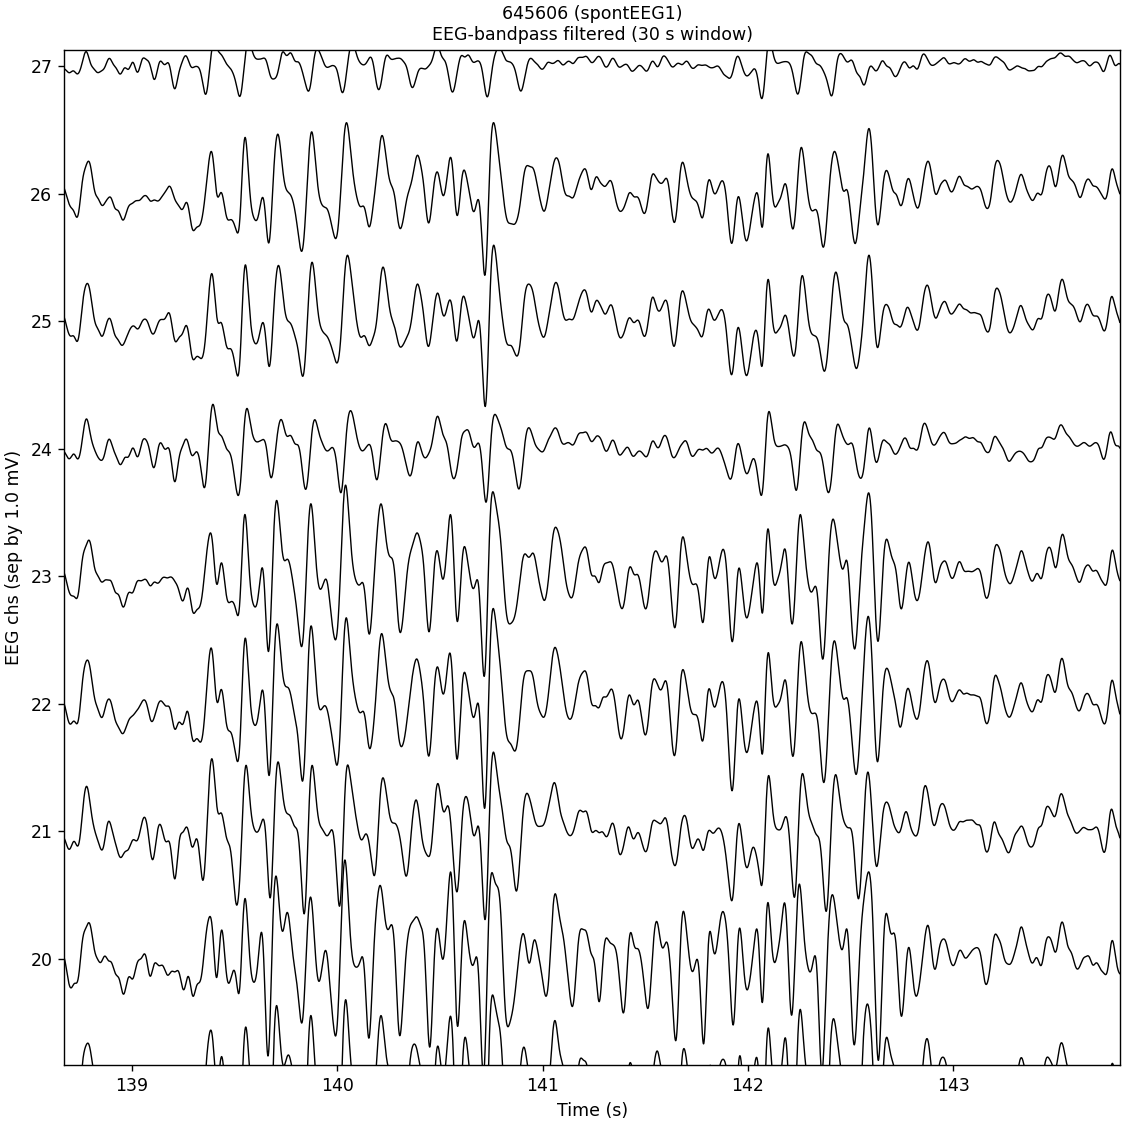

In [13]:
fig, ax = plt.subplots(figsize=(9, 9), constrained_layout=True)
for chi in eeg_chs:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(eeg_ts[plot_inds], filt_data[plot_inds, chi] + sep*chi, color=trace_color, linewidth=0.8)

ax.set_xlim(plot_window)
ax.set_xlabel('Time (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(eeg_chs)
ax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))
ax.set_title('{} ({})\nEEG-bandpass filtered ({:d} s window)'.format(exp.mouse, exp_tag, int(plot_window[1]-plot_window[0])))

### SAVE ###
fig_name = '{}_filtEEGstack_{:d}-{:d}s.png'.format(exp_tag, int(plot_window[0]), int(plot_window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Power spectrum

In [17]:
## Process the power spectrum across the whole recording ##
frex, Pxx = signal.welch(
    eeg_data, exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
)

<IPython.core.display.Javascript object>


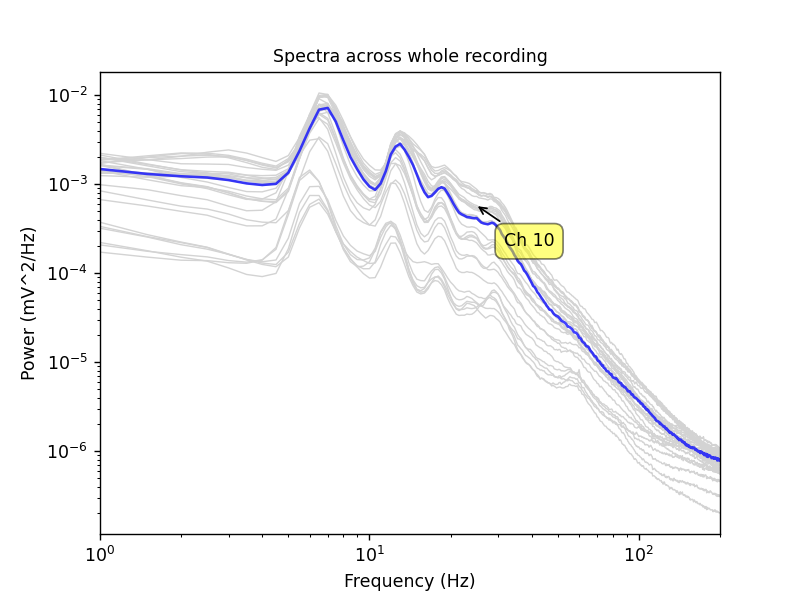

Text(0.5, 1.0, 'Spectra across whole recording')

In [18]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')

<IPython.core.display.Javascript object>


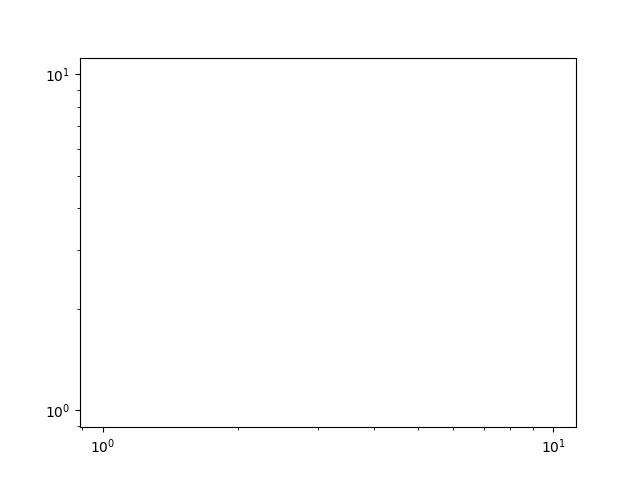

ValueError: array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.37254902e-01, 9.84002783e-02, 9.98785992e-01, 1.00000000e+00],
       [3.66666667e-01, 2.07911691e-01, 9.94521895e-01, 1.00000000e+00],
       [2.96078431e-01, 3.14869589e-01, 9.87201840e-01, 1.00000000e+00],
       [2.25490196e-01, 4.17960345e-01, 9.76848318e-01, 1.00000000e+00],
       [1.54901961e-01, 5.15917826e-01, 9.63493144e-01, 1.00000000e+00],
       [9.21568627e-02, 5.97707459e-01, 9.49134944e-01, 1.00000000e+00],
       [2.15686275e-02, 6.82748855e-01, 9.30229309e-01, 1.00000000e+00],
       [4.90196078e-02, 7.59404917e-01, 9.08465272e-01, 1.00000000e+00],
       [1.19607843e-01, 8.26734175e-01, 8.83909710e-01, 1.00000000e+00],
       [1.90196078e-01, 8.83909710e-01, 8.56638078e-01, 1.00000000e+00],
       [2.60784314e-01, 9.30229309e-01, 8.26734175e-01, 1.00000000e+00],
       [3.23529412e-01, 9.61825643e-01, 7.98017227e-01, 1.00000000e+00],
       [3.94117647e-01, 9.86200747e-01, 7.63398283e-01, 1.00000000e+00],
       [4.64705882e-01, 9.98463604e-01, 7.26433574e-01, 1.00000000e+00],
       [5.35294118e-01, 9.98463604e-01, 6.87236686e-01, 1.00000000e+00],
       [6.05882353e-01, 9.86200747e-01, 6.45928062e-01, 1.00000000e+00],
       [6.76470588e-01, 9.61825643e-01, 6.02634636e-01, 1.00000000e+00],
       [7.39215686e-01, 9.30229309e-01, 5.62592752e-01, 1.00000000e+00],
       [8.09803922e-01, 8.83909710e-01, 5.15917826e-01, 1.00000000e+00],
       [8.80392157e-01, 8.26734175e-01, 4.67657593e-01, 1.00000000e+00],
       [9.50980392e-01, 7.59404917e-01, 4.17960345e-01, 1.00000000e+00],
       [1.00000000e+00, 6.82748855e-01, 3.66978792e-01, 1.00000000e+00],
       [1.00000000e+00, 5.97707459e-01, 3.14869589e-01, 1.00000000e+00],
       [1.00000000e+00, 5.15917826e-01, 2.67733003e-01, 1.00000000e+00],
       [1.00000000e+00, 4.17960345e-01, 2.13933083e-01, 1.00000000e+00],
       [1.00000000e+00, 3.14869589e-01, 1.59475791e-01, 1.00000000e+00],
       [1.00000000e+00, 2.07911691e-01, 1.04528463e-01, 1.00000000e+00],
       [1.00000000e+00, 9.84002783e-02, 4.92599411e-02, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]]) is not a valid value for color

In [69]:
frinds = frex < 200

fig, ax = plt.subplots()

colors = plt.cm.rainbow(np.linspace(0, 1, Pxx.shape[1]))
spectra = ax.loglog(frex[frinds], Pxx[frinds,:], c=colors, linewidth=0.8)

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='k', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')

### Plotting

Plot the visual evoked response across all electrodes. This plots all electrodes in the array layout, with bad chs in red. You can choose to plot:
- 'raw': raw signals, averaged across all trials
- 'filtered': bandpass filtered signals, averaged across all trials
- 'common_averaged': raw signals that have been common average referenced to all good chs, then filtered and averaged across all trials

<IPython.core.display.Javascript object>


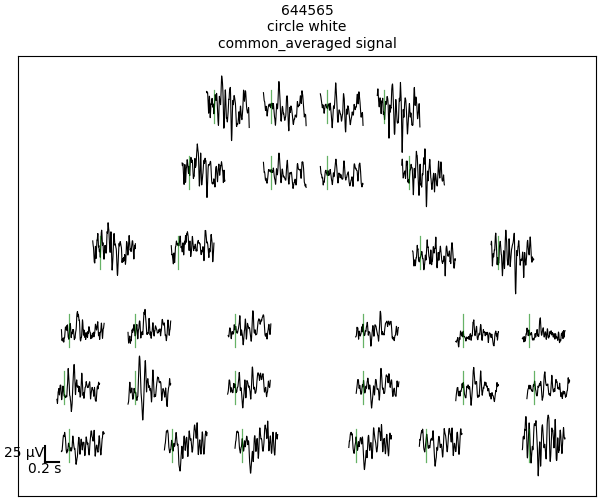

In [35]:
plot_stim_type = 'circle'
plot_stim_param = 'white'
plot_sweep = 0
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'

# if remove_bad_trials:
#     tag = 'good'
# else:
#     tag = 'all'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 80 # changes vertical distance between traces, usually 100 for VEPs

timex = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][0]
plottraces = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
#     ax.plot([0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#              0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#             [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#              25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#             color='r', linewidth=0.9, alpha=0.6)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.95
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_arrayplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)

## UNCOMMENT TO SAVE THE FIGURE ##
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

In [35]:
snr_dur = 0.2

binds = np.squeeze(np.argwhere((timex >= -snr_dur) & (timex < 0)))
rinds = np.squeeze(np.argwhere((timex > 0) & (timex <= snr_dur)))

base_power = np.mean(np.square(plottraces[binds, :]), axis=0)
resp_power = np.mean(np.square(plottraces[rinds, :]), axis=0)
snrs = np.sqrt(resp_power / base_power)
print(snrs)
print(np.mean(snrs))

[1.95017782 5.24227399 1.42381525 5.16199239 4.37454255 4.24241459
 3.51264115 1.21593842 3.83742894 1.8955301  1.89893429 1.8067833
 0.81062434 1.23805703 0.87227716 0.9842449  2.95423934 1.29269561
 4.07347692 2.26632062 1.86270402 1.81373157 0.51786046 0.52933825
 2.45093971 0.39612949 0.46196817 2.47845535 0.79152483 0.52708515]
2.0961381906796692


#### Same plot above, but as a butterfly plot

<IPython.core.display.Javascript object>


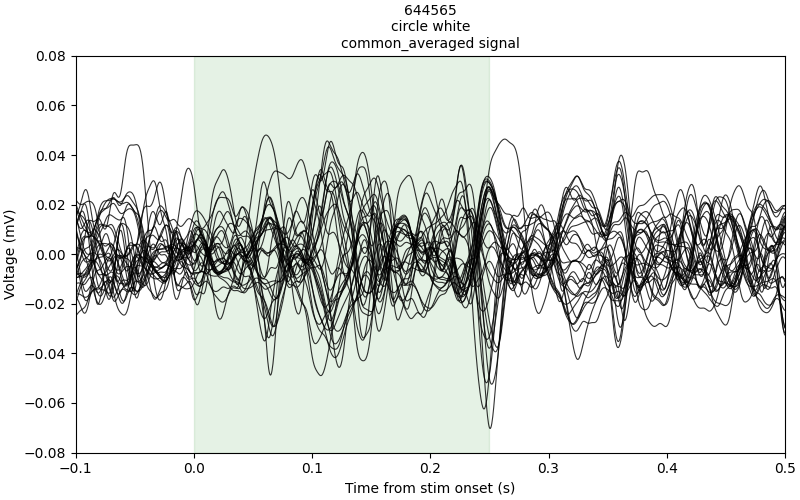

In [36]:
ylimit = 0.08 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_butterflyplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

#### Same plot, but with electrodes vertically stacked

<IPython.core.display.Javascript object>


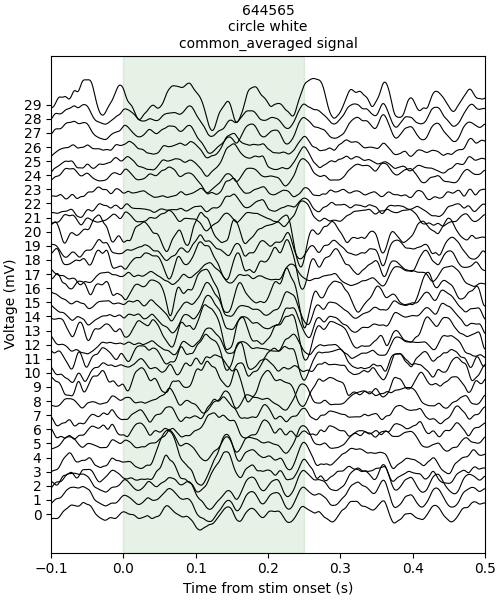

In [37]:
sep = 0.025 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(5, 6), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000 + sep*chi, color=trace_color, linewidth=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_xlabel('Time from stim onset (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(range(len(exp.EEG_channel_coordinates)))
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_stackedplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Plot whole traces

<IPython.core.display.Javascript object>


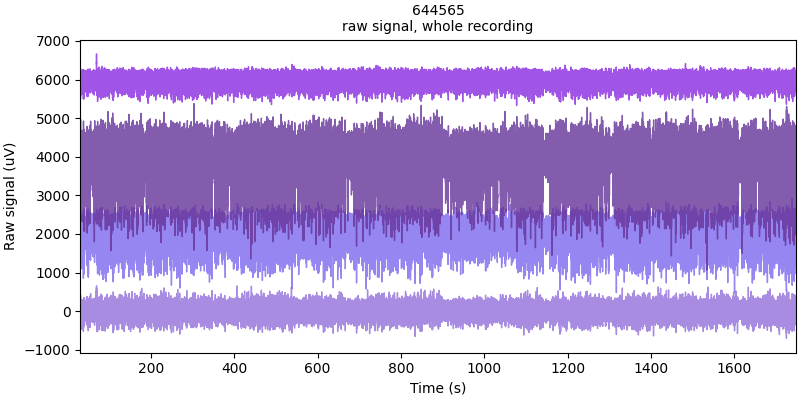

In [30]:
plot_chs = [0,3,13,27]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 2000 # 500
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

for i, chi in enumerate(plot_chs):
    ax.plot(eeg_ts, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))

ax.set_xlim((eeg_ts[0], eeg_ts[-1]))
# ax.set_ylim((-500, 2200))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('{}\nraw signal, whole recording'.format(exp.mouse))
# ax.legend()

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'whole_raw_signals.png'
fig.savefig(os.path.join(recfolder, fig_name), transparent=True)